In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs, pad_seqs_2step, calculate_output

In [2]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()


def run(model, train_data, epochs):

    model.train()
    loss_history = []
    for epoch in range(epochs):
        lossTotal = 0
        for x,y in train_data:
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history.append(lossTotal)

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        if epoch%100 == 0:
            print('epoch: ', epoch)
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
            if (epoch%100 == 2):
                if i%50 == 0:
                    if verbose:
                        print('\n################\nepoch: ',epoch, '\n################\n')
                        print('output =. ' , output.detach().numpy())
                        print('label =. ' , y.detach().numpy())
                        test_acc(model, test_data, hidden_size, verbose = True)
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model


def seq_acc(model, testset, hidden_size, rep = 10, verbose = False):
    
    train_inputs = convert_seq2inputs(testset, num_classes=num_classes, seq_len=5)
    testdata = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
    model.eval()
    trials = []
    accs = []
    for _ in range(rep):
        for j, (x,y) in enumerate(testdata):
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item() 
                accs.append(float(correct))
                curr_trial = testset[j*len(x)+i].copy()
                trials.append([x for x in curr_trial if x!= ('X', 'X')])
#                 trials.append(curr_trial)
    
    df = pd.DataFrame({'trial':trials, 'acc':accs})
    df['trial'] = df['trial'].apply(str)
    df = df.groupby(['trial']).mean()
           
    return df 

In [3]:

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue', 'black']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = 'loss', color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=14)

In [13]:
num_classes = 14
batchsize=1
# specs
input_size = num_classes
output_size = 1
num_layers = 1
learningRate = 0.001
hidden_size=20

# Experiment 1: trigrams

In [6]:
def exp1(p, trainseqs, testseqs):
    t1 = time.time()
    
    for val in trainseqs:
            if val in testseqs:
                testseqs.remove(val)

    padtrain = p + pad_seqs_2step(trainseqs)
    train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    padtest = pad_seqs_2step(testseqs)
    test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    
    # run
    t1 = time.time()
    res = Parallel(n_jobs = -1)(delayed(run_sims)(i, trainset, [trainset, testset]) for i in range(num_sims))

    # format results
    losses = np.hstack([r[0] for r in res])
    acc_train = np.array([r[1][:,0] for r in res]).T
    acc_test = np.array([r[1][:,1] for r in res]).T
    models = [r[2] for r in res]

    # calculate test accuracy on each trial type
    dfs=[]
    for mod in models:
        dfs.append(seq_acc(mod, padtest, hidden_size, rep = 100, verbose = False))
    df = pd.concat(dfs, axis=1)
    print(df.apply(np.mean, axis=1).sort_values(ascending = False))  
    
    # plot
    plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '')
    
    t2 = time.time()
    print('time: ', (t2-t1)/60)
    return losses, acc_train, acc_test, dfs, models

In [5]:
####### exp 1 - trian on 1

trial
['B', ('+', 'A'), 5]    1.0000
['A', ('+', 'B'), 5]    0.3125
['B', ('+', 'B'), 6]    0.1875
dtype: float64
time:  1.463548235098521


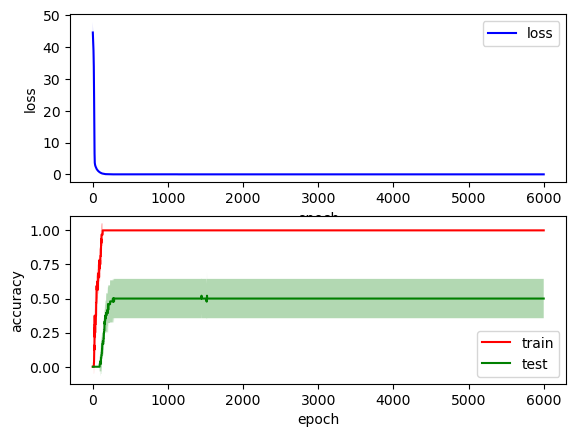

In [162]:
epochs = 6000
batchsize = 1
learningRate = 0.001

p = [['A', ('X','X'), ('X','X'), 2],\
     ['B', ('X','X'), ('X','X'), 3]]

trainseqs = generate_sequences(['+'], ['A'], len_seq = 1, init_values = ['A'])
testseqs = generate_sequences(['+'], ['A','B'], len_seq = 1, init_values = ['A','B'])

losses1, acc_train1, acc_test1, dfs1, models1 = exp1(p, trainseqs, testseqs)

trial
['B', ('+', 'A'), ('+', 'X'), 5]    1.00
['B', ('+', 'X'), ('+', 'A'), 5]    1.00
['B', ('+', 'B'), ('+', 'X'), 6]    0.50
['A', ('+', 'B'), ('+', 'X'), 5]    0.25
['A', ('+', 'X'), ('+', 'B'), 5]    0.00
['B', ('+', 'X'), ('+', 'B'), 6]    0.00
dtype: float64
time:  1.2103255311648051


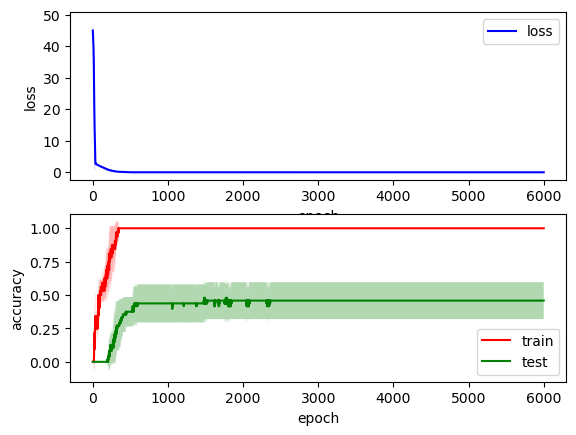

########## rep 3 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900
epoch:  5000
epoch:  5100
epoch:  5200
epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800
epoch:  5900
loss: 0.0 
########## rep 6 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  13

In [14]:
num_sims = 8
epochs = 6000
batchsize = 1
learningRate = 0.001

p = [['A', ('+','X'), ('+','X'), 2],\
     ['B', ('+','X'), ('+','X'), 3]]

trainseqs = generate_sequences(['+'], ['A'], len_seq = 1, init_values = ['A'])
testseqs = generate_sequences(['+'], ['A','B'], len_seq = 1, init_values = ['A','B'])

losses1, acc_train1, acc_test1, dfs1, models1 = exp1(p, trainseqs, testseqs)

In [16]:
dfs1

[                                  acc
 trial                                
 ['A', ('+', 'B'), ('+', 'X'), 5]  1.0
 ['A', ('+', 'X'), ('+', 'B'), 5]  0.0
 ['B', ('+', 'A'), ('+', 'X'), 5]  1.0
 ['B', ('+', 'B'), ('+', 'X'), 6]  1.0
 ['B', ('+', 'X'), ('+', 'A'), 5]  1.0
 ['B', ('+', 'X'), ('+', 'B'), 6]  0.0,
                                   acc
 trial                                
 ['A', ('+', 'B'), ('+', 'X'), 5]  0.0
 ['A', ('+', 'X'), ('+', 'B'), 5]  0.0
 ['B', ('+', 'A'), ('+', 'X'), 5]  1.0
 ['B', ('+', 'B'), ('+', 'X'), 6]  0.0
 ['B', ('+', 'X'), ('+', 'A'), 5]  1.0
 ['B', ('+', 'X'), ('+', 'B'), 6]  0.0,
                                   acc
 trial                                
 ['A', ('+', 'B'), ('+', 'X'), 5]  0.0
 ['A', ('+', 'X'), ('+', 'B'), 5]  0.0
 ['B', ('+', 'A'), ('+', 'X'), 5]  1.0
 ['B', ('+', 'B'), ('+', 'X'), 6]  0.0
 ['B', ('+', 'X'), ('+', 'A'), 5]  1.0
 ['B', ('+', 'X'), ('+', 'B'), 6]  0.0,
                                   acc
 trial                

trial
['A', ('+', 'B'), ('+', 'X'), 5]    1.0
['B', ('+', 'A'), ('+', 'X'), 5]    1.0
['B', ('+', 'B'), ('+', 'X'), 6]    1.0
['B', ('+', 'C'), ('+', 'X'), 8]    1.0
['B', ('+', 'X'), ('+', 'A'), 5]    1.0
['B', ('+', 'X'), ('+', 'C'), 8]    1.0
['C', ('+', 'B'), ('+', 'X'), 8]    1.0
['A', ('+', 'X'), ('+', 'B'), 5]    0.5
['B', ('+', 'X'), ('+', 'B'), 6]    0.5
['C', ('+', 'X'), ('+', 'B'), 8]    0.5
dtype: float64
time:  2.7631991346677145


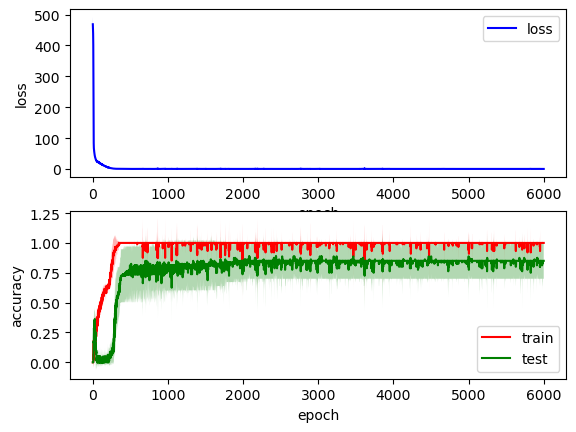

########## rep 0 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900
epoch:  5000
epoch:  5100
epoch:  5200
epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800
epoch:  5900
loss: 0.0 
########## rep 2 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  13

In [17]:
## exp 2 ########### - train on 2

epochs = 6000
p = [['A', ('+','X'), ('+','X'), 2],\
     ['C', ('+','X'), ('+','X'), 5],\
     ['B', ('+','X'), ('+','X'), 3]]

trainseqs = generate_sequences(['+'], ['A','C'], len_seq = 1, init_values = ['A','C'])
testseqs = generate_sequences(['+'], ['A','B','C'], len_seq = 1, init_values = ['A','B','C'])

losses2, acc_train2, acc_test2, dfs2, models2 = exp1(p, trainseqs, testseqs)

In [161]:
dfs2

[                      acc
 trial                    
 ['A', ('+', 'B'), 5]  0.5
 ['B', ('+', 'A'), 5]  1.0
 ['B', ('+', 'B'), 6]  0.5
 ['B', ('+', 'C'), 8]  1.0
 ['C', ('+', 'B'), 8]  0.5,
                       acc
 trial                    
 ['A', ('+', 'B'), 5]  1.0
 ['B', ('+', 'A'), 5]  1.0
 ['B', ('+', 'B'), 6]  1.0
 ['B', ('+', 'C'), 8]  1.0
 ['C', ('+', 'B'), 8]  1.0,
                       acc
 trial                    
 ['A', ('+', 'B'), 5]  1.0
 ['B', ('+', 'A'), 5]  1.0
 ['B', ('+', 'B'), 6]  1.0
 ['B', ('+', 'C'), 8]  1.0
 ['C', ('+', 'B'), 8]  1.0,
                       acc
 trial                    
 ['A', ('+', 'B'), 5]  1.0
 ['B', ('+', 'A'), 5]  1.0
 ['B', ('+', 'B'), 6]  0.5
 ['B', ('+', 'C'), 8]  1.0
 ['C', ('+', 'B'), 8]  1.0,
                       acc
 trial                    
 ['A', ('+', 'B'), 5]  0.5
 ['B', ('+', 'A'), 5]  1.0
 ['B', ('+', 'B'), 6]  0.5
 ['B', ('+', 'C'), 8]  1.0
 ['C', ('+', 'B'), 8]  0.5,
                       acc
 trial                 

trial
['B', ('+', 'A'), 5]     1.0000
['B', ('+', 'C'), 8]     1.0000
['B', ('+', 'D'), 10]    1.0000
['A', ('+', 'B'), 5]     0.5000
['C', ('+', 'B'), 8]     0.5000
['D', ('+', 'B'), 10]    0.5000
['B', ('+', 'B'), 6]     0.4375
dtype: float64
time:  6.077409998575846


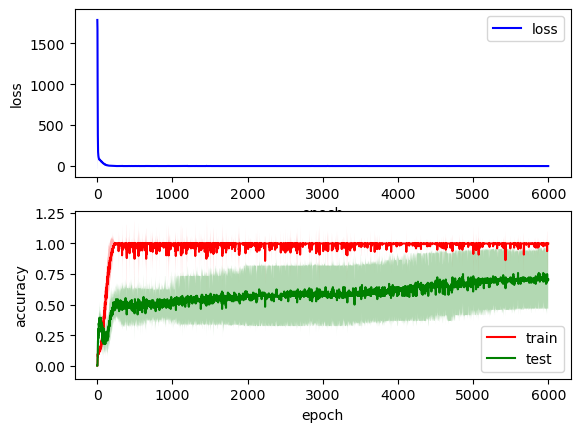

########## rep 1 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900
epoch:  5000
epoch:  5100
epoch:  5200
epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800
epoch:  5900
loss: 0.0 
########## rep 4 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  13

In [155]:
## exp 3 ########### - train on 3

epochs = 6000

p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7]
    ]

trainseqs = generate_sequences(['+'], ['A','C', 'D'], len_seq = 1, init_values = ['A', 'C',  'D'])
testseqs = generate_sequences(['+'], ['A','B','C', 'D'], len_seq = 1, init_values = ['A','B','C', 'D'])

losses3, acc_train3, acc_test3, dfs3, models3 = exp1(p, trainseqs, testseqs)

trial
['B', ('+', 'A'), 5]     0.7500
['B', ('+', 'C'), 8]     0.7500
['B', ('+', 'D'), 10]    0.7500
['B', ('+', 'E'), 4]     0.7500
['A', ('+', 'B'), 5]     0.4375
['C', ('+', 'B'), 8]     0.4375
['E', ('+', 'B'), 4]     0.4375
['D', ('+', 'B'), 10]    0.3750
['B', ('+', 'B'), 6]     0.3125
dtype: float64
time:  7.250039919217428


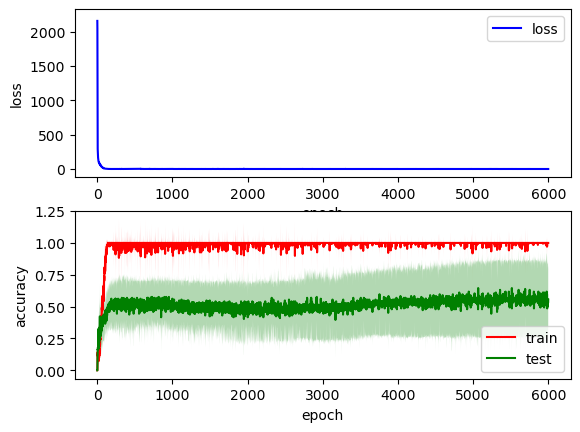

########## rep 4 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900
epoch:  5000
epoch:  5100
epoch:  5200
epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800
epoch:  5900
loss: 0.1 
########## rep 6 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  13

In [159]:
## exp 3.2 ########### - no primitives

epochs = 6000

p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1]
    ]

trainseqs = generate_sequences(['+'], ['A','C', 'D', 'E'], len_seq = 1, init_values = ['A', 'C',  'D', 'E'])
testseqs = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B','C', 'D', 'E'])

losses32, acc_train32, acc_test32, dfs32, models32 = exp1([], trainseqs, testseqs)

trial
['F', ('+', 'A'), 6]     1.0000
['F', ('+', 'B'), 7]     1.0000
['F', ('+', 'C'), 9]     1.0000
['F', ('+', 'E'), 5]     1.0000
['A', ('+', 'F'), 6]     0.9375
['C', ('+', 'F'), 9]     0.9375
['E', ('+', 'F'), 5]     0.9375
['F', ('+', 'D'), 11]    0.9375
['F', ('+', 'F'), 8]     0.9375
['B', ('+', 'F'), 7]     0.8750
['D', ('+', 'F'), 11]    0.8125
dtype: float64
time:  15.013510127862295


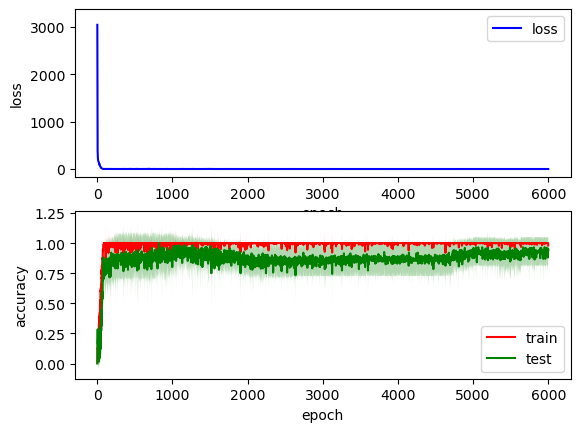

########## rep 0 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  1300
epoch:  1400
epoch:  1500
epoch:  1600
epoch:  1700
epoch:  1800
epoch:  1900
epoch:  2000
epoch:  2100
epoch:  2200
epoch:  2300
epoch:  2400
epoch:  2500
epoch:  2600
epoch:  2700
epoch:  2800
epoch:  2900
epoch:  3000
epoch:  3100
epoch:  3200
epoch:  3300
epoch:  3400
epoch:  3500
epoch:  3600
epoch:  3700
epoch:  3800
epoch:  3900
epoch:  4000
epoch:  4100
epoch:  4200
epoch:  4300
epoch:  4400
epoch:  4500
epoch:  4600
epoch:  4700
epoch:  4800
epoch:  4900
epoch:  5000
epoch:  5100
epoch:  5200
epoch:  5300
epoch:  5400
epoch:  5500
epoch:  5600
epoch:  5700
epoch:  5800
epoch:  5900
loss: 1.4 
########## rep 5 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
epoch:  1200
epoch:  13

In [157]:
# exp 4 ################## - train on 5

p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]
    ]

trainseqs = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B', 'C',  'D', 'E'])
testseqs = generate_sequences(['+'], ['A','B','C', 'D', 'E', 'F'], len_seq = 1, init_values = ['A','B','C', 'D', 'E', 'F'])

losses4, acc_train4, acc_test4, dfs4, models4 = exp1(p, trainseqs, testseqs)

trial
['F', ('+', 'E'), 5]     1.0000
['F', ('+', 'C'), 9]     0.9375
['F', ('+', 'G'), 13]    0.9375
['F', ('+', 'D'), 11]    0.9375
['F', ('+', 'A'), 6]     0.9375
['B', ('+', 'A'), 5]     0.8750
['B', ('+', 'C'), 8]     0.8750
['B', ('+', 'D'), 10]    0.8750
['B', ('+', 'E'), 4]     0.8750
['B', ('+', 'G'), 12]    0.8750
['A', ('+', 'F'), 6]     0.2500
['D', ('+', 'F'), 11]    0.1875
['B', ('+', 'F'), 7]     0.1875
['C', ('+', 'F'), 9]     0.1875
['E', ('+', 'F'), 5]     0.1875
['F', ('+', 'F'), 8]     0.1250
['G', ('+', 'F'), 13]    0.1250
['F', ('+', 'B'), 7]     0.0000
['E', ('+', 'B'), 4]     0.0000
['D', ('+', 'B'), 10]    0.0000
['C', ('+', 'B'), 8]     0.0000
['B', ('+', 'B'), 6]     0.0000
['G', ('+', 'B'), 12]    0.0000
['A', ('+', 'B'), 5]     0.0000
dtype: float64
time:  4.695775135358175


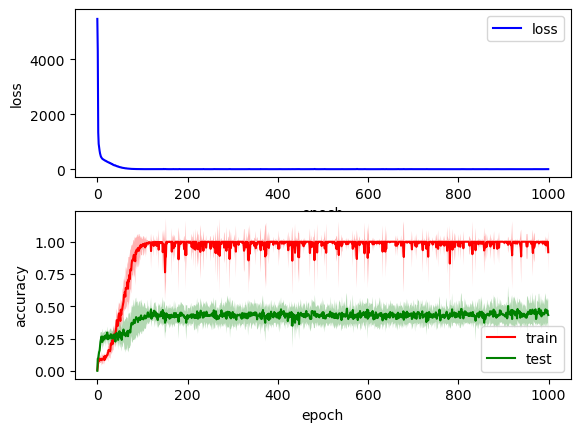

########## rep 4 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.0 
########## rep 0 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.1 
########## rep 6 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.1 
########## rep 0 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.6 
########## rep 0 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.2 
########## rep 6 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.0 
########## rep 7 #########
epoch:  0
epoch:  100
epoch:  200
epo

In [143]:
# exp 5 ---- train on 6

p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4],\
     ['G', ('X','X'), ('X','X'), 9]
    ]

trainseqs = generate_sequences(['+'], ['A','G','C', 'D', 'E'], len_seq = 1, init_values = ['A','G', 'C',  'D', 'E'])
testseqs = generate_sequences(['+'], ['A','B','C', 'D', 'E', 'F', 'G'], len_seq = 1, init_values = ['A','B','C', 'D', 'E', 'F', 'G'])

losses5, acc_train5, acc_test5, dfs5, models5 = exp1(p, trainseqs, testseqs)



trial
['A', ('+', 'E'), 3]     0.9375
['A', ('+', 'F'), 6]     0.9375
['B', ('+', 'F'), 7]     0.8750
['B', ('+', 'D'), 10]    0.8750
['B', ('+', 'G'), 12]    0.8750
['B', ('+', 'E'), 4]     0.8750
['B', ('+', 'C'), 8]     0.8750
['A', ('+', 'G'), 11]    0.8750
['A', ('+', 'D'), 9]     0.8750
['A', ('+', 'C'), 7]     0.8750
['B', ('+', 'B'), 6]     0.1250
['A', ('+', 'B'), 5]     0.1250
['B', ('+', 'A'), 5]     0.0625
['E', ('+', 'A'), 3]     0.0000
['G', ('+', 'A'), 11]    0.0000
['F', ('+', 'B'), 7]     0.0000
['F', ('+', 'A'), 6]     0.0000
['E', ('+', 'B'), 4]     0.0000
['A', ('+', 'A'), 4]     0.0000
['D', ('+', 'B'), 10]    0.0000
['D', ('+', 'A'), 9]     0.0000
['C', ('+', 'B'), 8]     0.0000
['C', ('+', 'A'), 7]     0.0000
['G', ('+', 'B'), 12]    0.0000
dtype: float64
time:  8.789072183767955


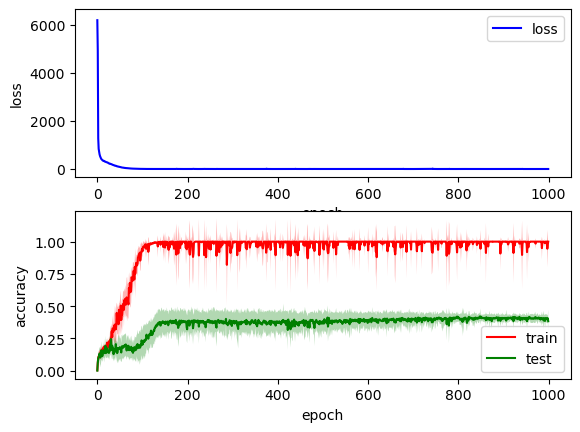

In [86]:
# exp 6

p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4],\
     ['G', ('X','X'), ('X','X'), 9]
    ]

trainseqs = generate_sequences(['+'], ['C', 'D', 'E', 'F', 'G'], len_seq = 1, init_values = ['C',  'D', 'E', 'F', 'G'])
testseqs = generate_sequences(['+'], ['A','B','C', 'D', 'E', 'F', 'G'], len_seq = 1, init_values = ['A','B','C', 'D', 'E', 'F', 'G'])

losses6, acc_train6, acc_test6, dfs6, models6 = exp1(p, trainseqs, testseqs)


trial
['F', ('-', 'A'), 2]     1.0000
['F', ('-', 'B'), 1]     1.0000
['F', ('-', 'C'), -1]    1.0000
['F', ('-', 'D'), -3]    1.0000
['F', ('-', 'E'), 3]     1.0000
['A', ('-', 'F'), -2]    0.8125
['B', ('-', 'F'), -1]    0.7500
['C', ('-', 'F'), 1]     0.7500
['F', ('-', 'F'), 0]     0.7500
['D', ('-', 'F'), 3]     0.6875
['E', ('-', 'F'), -3]    0.6875
dtype: float64
time:  2.147367521127065


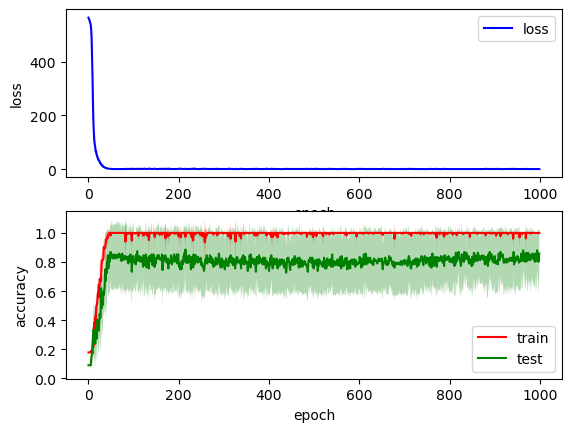

In [93]:
# exp 7

epochs = 1000 
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]]

trainseqs = generate_sequences(['-'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B','C', 'D', 'E'])
testseqs = generate_sequences(['-'], ['A','B','C', 'D', 'E', 'F'], len_seq = 1, init_values = ['A','B','C', 'D', 'E', 'F'])

losses7, acc_train7, acc_test7, dfs7, models7 = exp1(p, trainseqs, testseqs)


trial
['B', ('-', 'E'), 2]     1.0000
['B', ('-', 'A'), 1]     0.9375
['B', ('-', 'C'), -2]    0.9375
['B', ('-', 'D'), -4]    0.9375
['B', ('-', 'F'), -1]    0.9375
['F', ('-', 'B'), 1]     0.9375
['D', ('-', 'B'), 4]     0.8750
['B', ('-', 'B'), 0]     0.8125
['C', ('-', 'B'), 2]     0.8125
['A', ('-', 'B'), -1]    0.6875
['E', ('-', 'B'), -2]    0.6875
dtype: float64
time:  2.187150784333547


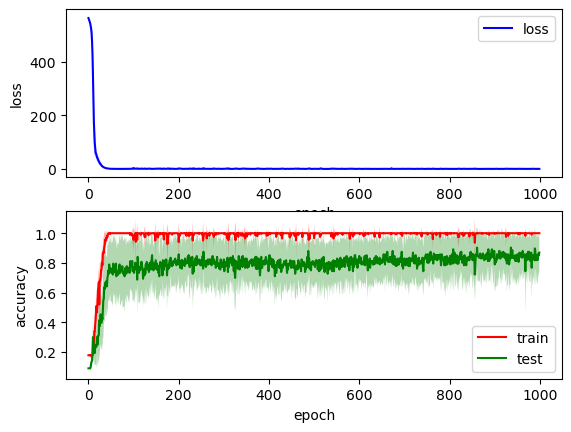

In [95]:
# exp 8

epochs = 1000 
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]]

trainseqs = generate_sequences(['-'], ['A','C', 'D', 'E', 'F'], len_seq = 1, init_values = ['A','C', 'D', 'E','F'])
testseqs = generate_sequences(['-'], ['A','B','C', 'D', 'E', 'F'], len_seq = 1, init_values = ['A','B','C', 'D', 'E', 'F'])

losses8, acc_train8, acc_test8, dfs8, models8 = exp1(p, trainseqs, testseqs)


trial
['C', ('-', 'E'), 4]     0.9375
['C', ('-', 'A'), 3]     0.8750
['C', ('-', 'B'), 2]     0.8750
['C', ('-', 'D'), -2]    0.7500
['B', ('-', 'C'), -2]    0.2500
['A', ('-', 'C'), -3]    0.1875
['C', ('-', 'C'), 0]     0.1875
['E', ('-', 'C'), -4]    0.1875
['D', ('-', 'C'), 2]     0.0625
dtype: float64
time:  1.4789011319478353


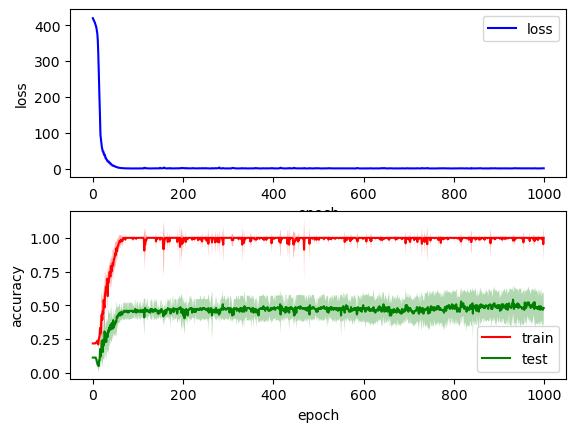

In [96]:
# exp 7

epochs = 1000 
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1]]

trainseqs = generate_sequences(['-'], ['A','B','D', 'E'], len_seq = 1, init_values = ['A','B', 'D', 'E'])
testseqs = generate_sequences(['-'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B','C', 'D', 'E'])

losses9, acc_train9, acc_test9, dfs9, models9 = exp1(p, trainseqs, testseqs)


trial
['D', ('-', 'B'), 4]     0.6250
['D', ('-', 'E'), 6]     0.5625
['D', ('-', 'A'), 5]     0.5000
['D', ('-', 'C'), 2]     0.5000
['A', ('-', 'D'), -5]    0.0000
['B', ('-', 'D'), -4]    0.0000
['C', ('-', 'D'), -2]    0.0000
['D', ('-', 'D'), 0]     0.0000
['E', ('-', 'D'), -6]    0.0000
dtype: float64
time:  1.9238009969393413


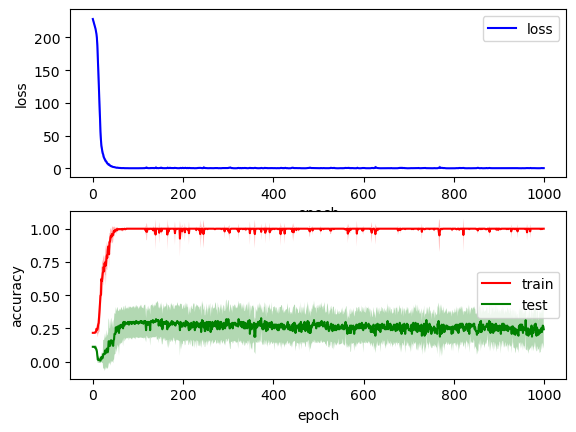

########## rep 6 #########
loss: 0.1 
########## rep 5 #########
loss: 0.4 
########## rep 1 #########
loss: 0.2 
########## rep 5 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.3 
########## rep 2 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.1 
########## rep 5 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.4 
########## rep 4 #########
loss: 0.0 
########## rep 0 #########
loss: 0.3 
########## rep 0 #########
loss: 1.0 
########## rep 0 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
loss: 0.5 
########## rep 1 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
los

In [97]:
# exp 10

epochs = 1000 
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1]]

trainseqs = generate_sequences(['-'], ['A','B','C', 'E'], len_seq = 1, init_values = ['A','B', 'C', 'E'])
testseqs = generate_sequences(['-'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B','C', 'D', 'E'])

losses10, acc_train10, acc_test10, dfs10, models10 = exp1(p, trainseqs, testseqs)


trial
['F', ('-', 'A'), 2]     1.0000
['F', ('-', 'E'), 3]     1.0000
['F', ('-', 'B'), 1]     0.9375
['F', ('-', 'C'), -1]    0.9375
['F', ('-', 'D'), -3]    0.9375
['B', ('-', 'F'), -1]    0.8750
['A', ('-', 'F'), -2]    0.7500
['C', ('-', 'F'), 1]     0.7500
['E', ('-', 'F'), -3]    0.7500
['F', ('-', 'F'), 0]     0.7500
['D', ('-', 'F'), 3]     0.6875
dtype: float64
time:  5.6376658320426944


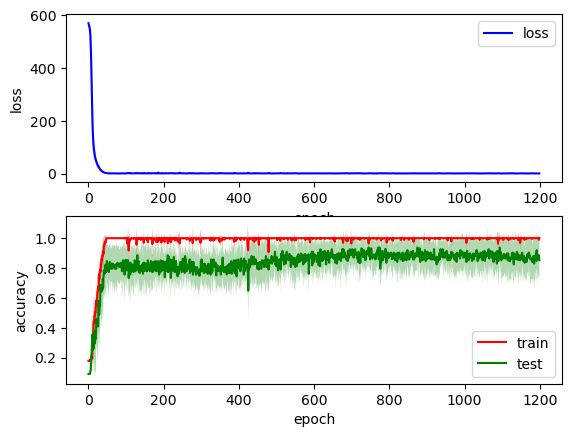

########## rep 0 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
loss: 0.0 
########## rep 6 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
loss: 0.1 
########## rep 4 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
loss: 2.4 
########## rep 3 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
loss: 0.7 
########## rep 5 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch:  500
epoch:  600
epoch:  700
epoch:  800
epoch:  900
epoch:  1000
epoch:  1100
loss: 0.2 
########## rep 1 #########
epoch:  0
epoch:  100
epoch:  200
epoch:  300
epoch:  400
epoch

In [98]:
# exp 11

epochs = 1200 
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]]

trainseqs = generate_sequences(['-'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B','C', 'D', 'E'])
testseqs = generate_sequences(['-'], ['A','B','C', 'D', 'E', 'F'], len_seq = 1, init_values = ['A','B','C', 'D', 'E', 'F'])

losses7, acc_train7, acc_test7, dfs7, models7 = exp1(p, trainseqs, testseqs)


trial
['C', ('+', 'B'), 8]     0.8750
['B', ('+', 'C'), 8]     0.0625
['B', ('*', 'C'), 15]    0.0000
['C', ('*', 'B'), 15]    0.0000
['C', ('*', 'C'), 25]    0.0000
['C', ('+', 'C'), 10]    0.0000
dtype: float64


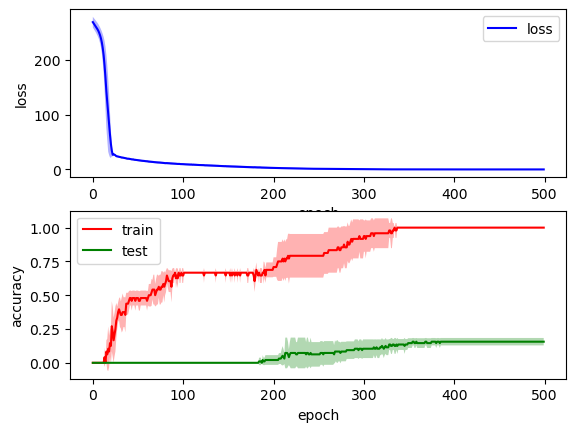

In [38]:
p = [['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3]]

trainseqs = generate_sequences(['+','*'], ['B'], len_seq = 1, init_values = ['B'])
testseqs = generate_sequences(['+','*'], ['C','B'], len_seq = 1, init_values = ['C','B'])

for val in trainseqs:
        if val in testseqs:
            testseqs.remove(val)
            
padtrain = p + pad_seqs_2step(trainseqs)
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
padtest = pad_seqs_2step(testseqs)
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

# run
num_sims = 8
epochs = 500
res = Parallel(n_jobs = -1)(delayed(run_sims)(i, trainset, [trainset, testset]) for i in range(num_sims))

# format results
losses = np.hstack([r[0] for r in res])
acc_train = np.array([r[1][:,0] for r in res]).T
acc_test = np.array([r[1][:,1] for r in res]).T
models = [r[2] for r in res]

# calculate test accuracy on each trial type
dfs=[]
for mod in models:
    dfs.append(seq_acc(mod, padtest, hidden_size, rep = 50, verbose = False))
df = pd.concat(dfs, axis=1)
print(df.apply(np.mean, axis=1).sort_values(ascending = False))  

# plot
plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '') 

In [ ]:
# exp 3.1 ###################

trial
['A', ('+', 'B'), 5]    0.7500
['A', ('+', 'C'), 7]    0.6250
['A', ('+', 'A'), 4]    0.3125
['B', ('+', 'A'), 5]    0.0625
['C', ('+', 'A'), 7]    0.0625
dtype: float64


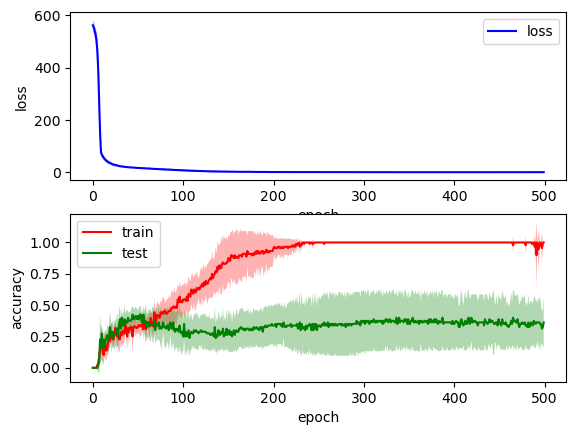

In [43]:
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3]]

trainseqs = generate_sequences(['+'], ['B','C'], len_seq = 1, init_values = ['B','C'])
testseqs = generate_sequences(['+'], ['A','B','C'], len_seq = 1, init_values = ['A','B','C'])

for val in trainseqs:
        if val in testseqs:
            testseqs.remove(val)
            
padtrain = p + pad_seqs_2step(trainseqs)
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
padtest = pad_seqs_2step(testseqs)
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

# run
num_sims = 8
epochs = 500
res = Parallel(n_jobs = -1)(delayed(run_sims)(i, trainset, [trainset, testset]) for i in range(num_sims))

# format results
losses = np.hstack([r[0] for r in res])
acc_train = np.array([r[1][:,0] for r in res]).T
acc_test = np.array([r[1][:,1] for r in res]).T
models = [r[2] for r in res]

# calculate test accuracy on each trial type
dfs=[]
for mod in models:
    dfs.append(seq_acc(mod, padtest, hidden_size, rep = 50, verbose = False))
df = pd.concat(dfs, axis=1)
print(df.apply(np.mean, axis=1).sort_values(ascending = False))  

# plot
plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '') 

In [ ]:
# exp 3.2 ###########

trial
['B', ('+', 'A'), 5]    1.0000
['B', ('+', 'C'), 8]    1.0000
['A', ('+', 'B'), 5]    0.4375
['C', ('+', 'B'), 8]    0.4375
['B', ('+', 'B'), 6]    0.3750
dtype: float64


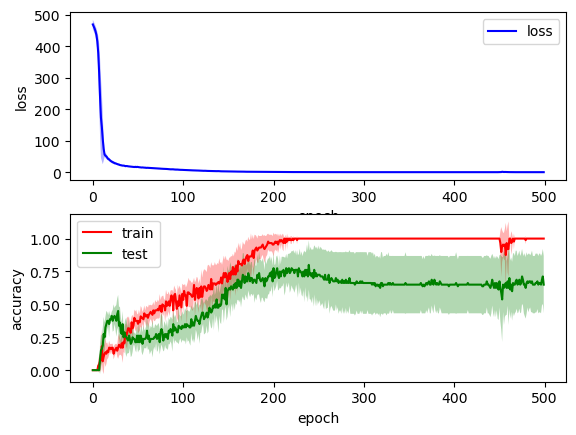

In [41]:
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3]]

trainseqs = generate_sequences(['+'], ['A','C'], len_seq = 1, init_values = ['A','C'])
testseqs = generate_sequences(['+'], ['A','B','C'], len_seq = 1, init_values = ['A','B','C'])

for val in trainseqs:
        if val in testseqs:
            testseqs.remove(val)
            
padtrain = p + pad_seqs_2step(trainseqs)
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
padtest = pad_seqs_2step(testseqs)
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

# run
num_sims = 8
epochs = 500
res = Parallel(n_jobs = -1)(delayed(run_sims)(i, trainset, [trainset, testset]) for i in range(num_sims))

# format results
losses = np.hstack([r[0] for r in res])
acc_train = np.array([r[1][:,0] for r in res]).T
acc_test = np.array([r[1][:,1] for r in res]).T
models = [r[2] for r in res]

# calculate test accuracy on each trial type
dfs=[]
for mod in models:
    dfs.append(seq_acc(mod, padtest, hidden_size, rep = 50, verbose = False))
df = pd.concat(dfs, axis=1)
print(df.apply(np.mean, axis=1).sort_values(ascending = False))  

# plot
plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '') 

In [171]:
# exp 3.3 #############

trial
['C', ('+', 'B'), 8]     1.0000
['C', ('+', 'A'), 7]     0.9375
['A', ('+', 'C'), 7]     0.0000
['B', ('+', 'C'), 8]     0.0000
['C', ('+', 'C'), 10]    0.0000
dtype: float64


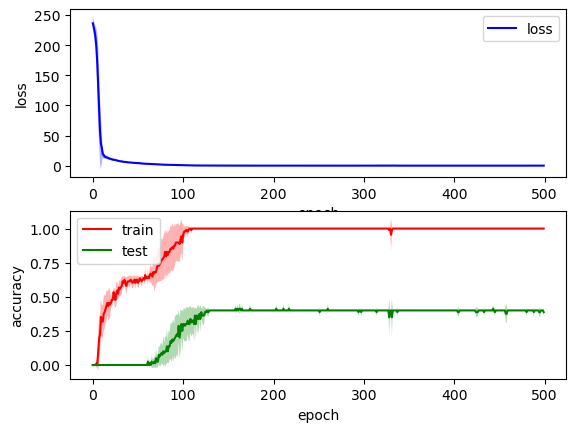

In [42]:
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3]]

trainseqs = generate_sequences(['+'], ['A','B'], len_seq = 1, init_values = ['A','B'])
testseqs = generate_sequences(['+'], ['A','B','C'], len_seq = 1, init_values = ['A','B','C'])

for val in trainseqs:
        if val in testseqs:
            testseqs.remove(val)
            
padtrain = p + pad_seqs_2step(trainseqs)
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
padtest = pad_seqs_2step(testseqs)
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

# run
num_sims = 8
epochs = 500
res = Parallel(n_jobs = -1)(delayed(run_sims)(i, trainset, [trainset, testset]) for i in range(num_sims))

# format results
losses = np.hstack([r[0] for r in res])
acc_train = np.array([r[1][:,0] for r in res]).T
acc_test = np.array([r[1][:,1] for r in res]).T
models = [r[2] for r in res]

# calculate test accuracy on each trial type
dfs=[]
for mod in models:
    dfs.append(seq_acc(mod, padtest, hidden_size, rep = 50, verbose = False))
df = pd.concat(dfs, axis=1)
print(df.apply(np.mean, axis=1).sort_values(ascending = False))  

# plot
plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '') 

In [ ]:
# exp 4 ############################

trial
['E', ('+', 'C'), 6]    0.7500
['E', ('+', 'A'), 3]    0.6875
['E', ('+', 'B'), 4]    0.6875
['E', ('+', 'D'), 8]    0.6250
['E', ('+', 'E'), 2]    0.1250
['A', ('+', 'E'), 3]    0.0000
['B', ('+', 'E'), 4]    0.0000
['C', ('+', 'E'), 6]    0.0000
['D', ('+', 'E'), 8]    0.0000
dtype: float64


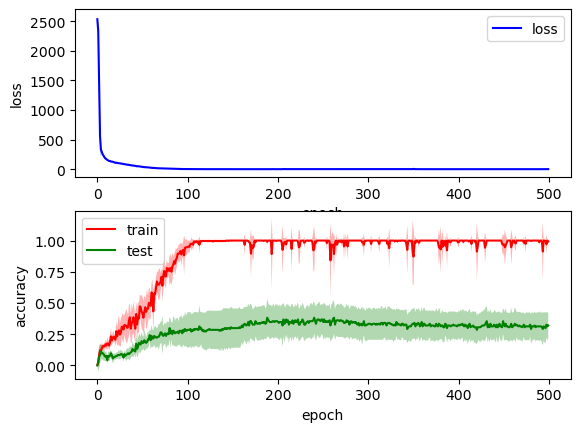

In [47]:
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1]
    ]

trainseqs = generate_sequences(['+'], ['A','B','C', 'D'], len_seq = 1, init_values = ['A','B', 'C',  'D'])
testseqs = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B','C', 'D', 'E'])

for val in trainseqs:
        if val in testseqs:
            testseqs.remove(val)
            
padtrain = p + pad_seqs_2step(trainseqs)
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
padtest = pad_seqs_2step(testseqs)
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

# run
num_sims = 8
epochs = 500
res = Parallel(n_jobs = -1)(delayed(run_sims)(i, trainset, [trainset, testset]) for i in range(num_sims))

# format results
losses = np.hstack([r[0] for r in res])
acc_train = np.array([r[1][:,0] for r in res]).T
acc_test = np.array([r[1][:,1] for r in res]).T
models = [r[2] for r in res]

# calculate test accuracy on each trial type
dfs=[]
for mod in models:
    dfs.append(seq_acc(mod, padtest, hidden_size, rep = 50, verbose = False))
df = pd.concat(dfs, axis=1)
print(df.apply(np.mean, axis=1).sort_values(ascending = False))  

# plot
plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '') 

trial
['F', ('+', 'A'), 6]     0.9375
['F', ('+', 'B'), 7]     0.9375
['F', ('+', 'C'), 9]     0.9375
['F', ('+', 'D'), 11]    0.9375
['F', ('+', 'E'), 5]     0.9375
['A', ('+', 'F'), 6]     0.8750
['B', ('+', 'F'), 7]     0.8750
['E', ('+', 'F'), 5]     0.8750
['C', ('+', 'F'), 9]     0.7500
['D', ('+', 'F'), 11]    0.7500
['F', ('+', 'F'), 8]     0.6875
dtype: float64


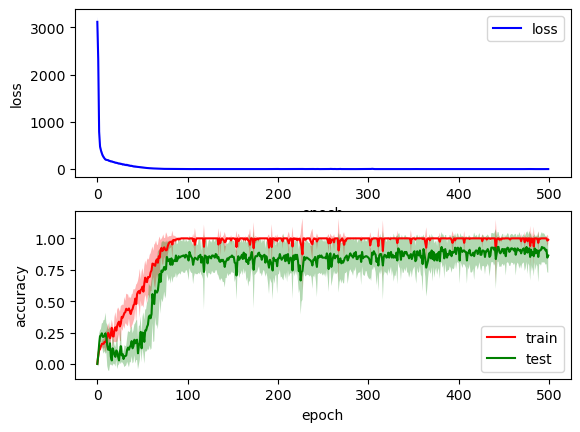

########## rep 5 #########
loss: 0.0 
########## rep 0 #########
loss: 2.9 
########## rep 1 #########
loss: 0.1 
########## rep 4 #########
loss: 0.1 
########## rep 3 #########
loss: 0.1 
########## rep 2 #########
loss: 0.3 
########## rep 7 #########
loss: 2.0 
########## rep 6 #########
loss: 0.1 


In [46]:
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4]
    ]

trainseqs = generate_sequences(['+'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B', 'C',  'D', 'E'])
testseqs = generate_sequences(['+'], ['A','B','C', 'D', 'E', 'F'], len_seq = 1, init_values = ['A','B','C', 'D', 'E', 'F'])

for val in trainseqs:
        if val in testseqs:
            testseqs.remove(val)
            
padtrain = p + pad_seqs_2step(trainseqs)
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
padtest = pad_seqs_2step(testseqs)
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

# run
num_sims = 8
epochs = 500
res = Parallel(n_jobs = -1)(delayed(run_sims)(i, trainset, [trainset, testset]) for i in range(num_sims))

# format results
losses = np.hstack([r[0] for r in res])
acc_train = np.array([r[1][:,0] for r in res]).T
acc_test = np.array([r[1][:,1] for r in res]).T
models = [r[2] for r in res]

# calculate test accuracy on each trial type
dfs=[]
for mod in models:
    dfs.append(seq_acc(mod, padtest, hidden_size, rep = 50, verbose = False))
df = pd.concat(dfs, axis=1)
print(df.apply(np.mean, axis=1).sort_values(ascending = False))  

# plot
plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '') 

trial
['E', ('+', 'C'), 6]    0.3125
['E', ('+', 'D'), 8]    0.2500
['E', ('+', 'A'), 3]    0.2500
['B', ('+', 'E'), 4]    0.1875
['E', ('+', 'B'), 4]    0.1875
['C', ('+', 'E'), 6]    0.1250
['D', ('+', 'E'), 8]    0.1250
['A', ('+', 'E'), 3]    0.1250
['E', ('*', 'B'), 3]    0.0625
['E', ('*', 'E'), 1]    0.0625
['E', ('+', 'E'), 2]    0.0625
['E', ('*', 'D'), 7]    0.0000
['E', ('*', 'C'), 5]    0.0000
['E', ('*', 'A'), 2]    0.0000
['D', ('*', 'E'), 7]    0.0000
['C', ('*', 'E'), 5]    0.0000
['B', ('*', 'E'), 3]    0.0000
['A', ('*', 'E'), 2]    0.0000
dtype: float64


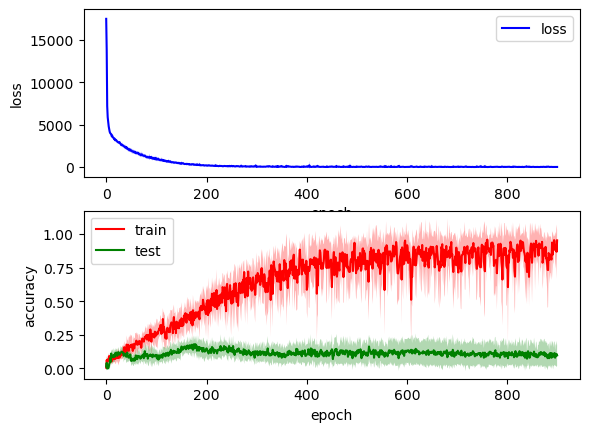

########## rep 3 #########
loss: 30.5 
########## rep 0 #########
loss: 74.6 
########## rep 0 #########
loss: 6.2 
########## rep 5 #########
loss: 2.0 
########## rep 0 #########
loss: 13.1 
########## rep 0 #########
loss: 5.4 
########## rep 0 #########
loss: 17.0 
########## rep 2 #########
loss: 13.3 
########## rep 1 #########
loss: 11.9 
########## rep 1 #########
loss: 24.9 
########## rep 0 #########
loss: 3.3 
########## rep 7 #########
loss: 3.0 
########## rep 3 #########
loss: 33.1 
########## rep 7 #########
loss: 1.4 
########## rep 4 #########
loss: 47.5 
########## rep 6 #########
loss: 3.6 
########## rep 2 #########
loss: 4.7 
########## rep 2 #########
loss: 7.0 
########## rep 6 #########
loss: 9.6 
########## rep 7 #########
loss: 13.1 
########## rep 6 #########
loss: 1.0 
########## rep 6 #########
loss: 68.1 
########## rep 2 #########
loss: 3.7 
########## rep 4 #########
loss: 15.3 
########## rep 6 #########
loss: 11.4 
########## rep 1 #########
loss: 0.5 

In [55]:
p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1]
    ]

trainseqs = generate_sequences(['+','*'], ['A','B','C', 'D'], len_seq = 1, init_values = ['A','B', 'C',  'D'])
testseqs = generate_sequences(['+', '*'], ['A','B','C', 'D', 'E'], len_seq = 1, init_values = ['A','B','C', 'D', 'E'])

for val in trainseqs:
        if val in testseqs:
            testseqs.remove(val)
            
padtrain = p + pad_seqs_2step(trainseqs)
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
padtest = pad_seqs_2step(testseqs)
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

# run
num_sims = 8
epochs = 900
res = Parallel(n_jobs = -1)(delayed(run_sims)(i, trainset, [trainset, testset]) for i in range(num_sims))

# format results
losses = np.hstack([r[0] for r in res])
acc_train = np.array([r[1][:,0] for r in res]).T
acc_test = np.array([r[1][:,1] for r in res]).T
models = [r[2] for r in res]

# calculate test accuracy on each trial type
dfs=[]
for mod in models:
    dfs.append(seq_acc(mod, padtest, hidden_size, rep = 50, verbose = False))
df = pd.concat(dfs, axis=1)
print(df.apply(np.mean, axis=1).sort_values(ascending = False))  

# plot
plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '') 

In [68]:
learningRate = 0.01

time:  8.623663647969563
trial
['B', ('*', 'E'), 3]     0.1875
['B', ('*', 'C'), 15]    0.1250
['D', ('*', 'B'), 21]    0.1250
['A', ('*', 'B'), 6]     0.0625
['B', ('*', 'F'), 12]    0.0625
['F', ('*', 'B'), 12]    0.0625
['B', ('*', 'A'), 6]     0.0000
['B', ('*', 'B'), 9]     0.0000
['B', ('*', 'D'), 21]    0.0000
['B', ('*', 'G'), 27]    0.0000
['B', ('*', 'H'), 33]    0.0000
['C', ('*', 'B'), 15]    0.0000
['E', ('*', 'B'), 3]     0.0000
['G', ('*', 'B'), 27]    0.0000
['H', ('*', 'B'), 33]    0.0000
dtype: float64


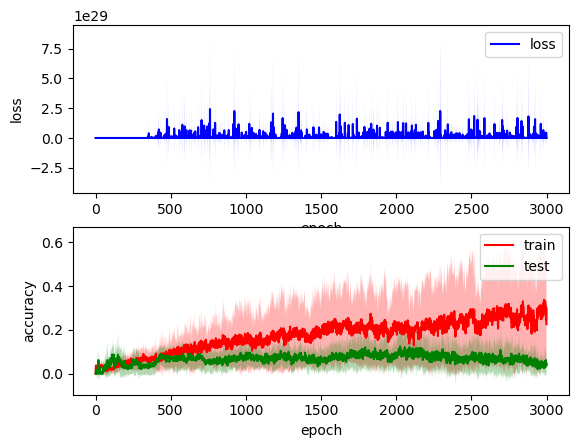

In [69]:
batchsize = 40

p = [['A', ('X','X'), ('X','X'), 2],\
     ['C', ('X','X'), ('X','X'), 5],\
     ['B', ('X','X'), ('X','X'), 3],\
     ['D', ('X','X'), ('X','X'), 7],\
     ['E', ('X','X'), ('X','X'), 1],\
     ['F', ('X','X'), ('X','X'), 4],\
     ['G', ('X','X'), ('X','X'), 9],\
     ['H', ('X','X'), ('X','X'), 11]
    ]

trainseqs = generate_sequences(['*'], ['A','C', 'D', 'E', 'F', 'G', 'H'], len_seq = 1, init_values = ['A', 'C',  'D', 'E', 'F', 'G', 'H'])
testseqs = generate_sequences(['*'], ['A','B','C', 'D', 'E', 'F', 'G','H'], len_seq = 1, init_values = ['A','B','C', 'D', 'E', 'F', 'G', 'H'])

for val in trainseqs:
        if val in testseqs:
            testseqs.remove(val)
            
padtrain = p + pad_seqs_2step(trainseqs)
train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
padtest = pad_seqs_2step(testseqs)
test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

# run
t1 = time.time()
num_sims = 8
epochs = 3000
res = Parallel(n_jobs = -1)(delayed(run_sims)(i, trainset, [trainset, testset]) for i in range(num_sims))
t2 = time.time()
print('time: ',( t2-t1)/60)
# format results
losses = np.hstack([r[0] for r in res])
acc_train = np.array([r[1][:,0] for r in res]).T
acc_test = np.array([r[1][:,1] for r in res]).T
models = [r[2] for r in res]

# calculate test accuracy on each trial type
dfs=[]
for mod in models:
    dfs.append(seq_acc(mod, padtest, hidden_size, rep = 50, verbose = False))
df = pd.concat(dfs, axis=1)
print(df.apply(np.mean, axis=1).sort_values(ascending = False))  

# plot
plotNNs([losses], [acc_train, acc_test], ['train', 'test'], ['red', 'green'], '') 

In [58]:
losses[-1,:]

array([ 41.53092528,   9.97043276, 100.47250427, 161.10246175,
        24.72731262,   4.00985443,  48.63211511,   7.0189521 ])

In [65]:
len(padtrain)

106